#### Experiments

#### decoder_state_dict_adamw_25e_bs64_ffdim_4096_heads_32_mseloss_0.07`
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=1,
    num_heads=32,
    ff_dim=4096,
    output_channels=3
)
```

#### 'decoder_state_dict_adamw_50e_numblocks_2_ffdim_2048_heads_16_mseloss_0.06.pth'
```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=2048,
    output_channels=3
)
```

#### ??

```
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
```

In [1]:
import os
os.chdir('ml-fastvit')

In [2]:
import timm
import torch
import models
import math
import matplotlib.pyplot as plt
import numpy as np
import gc

import torchvision.transforms as T
import torch.nn as nn
from torch import Tensor
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.utils as vutils

from timm.models import create_model
from models.modules.mobileone import reparameterize_model
from PIL import Image
from urllib.request import urlopen

# Before starting the training, make sure to clear any residual memory
gc.collect()
torch.cuda.empty_cache()

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

If for semantic segmentation, please install mmsegmentation first
If for detection, please install mmdetection first
cuda


In [3]:
def imshow(img, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):
    """Imshow for Tensor."""
    img = img.numpy().transpose((1, 2, 0))
    # img = std * img + mean  # unnormalize
    # img = np.clip(img, 0, 1)  # clip any values outside the range [0, 1]
    plt.imshow(img)
    plt.show()

In [4]:
class GELU(nn.Module):
    def forward(self, input: Tensor) -> Tensor:
        return F.gelu(input)

## Decoder Architecture v1 (best MSE Loss 0.068)

In [5]:
class TransformerDecoderBlock(nn.Module):
    def __init__(self, embed_dim, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.linear1 = nn.Linear(embed_dim, ff_dim)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(ff_dim, embed_dim)

        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.norm1(x)
        x = x + self.dropout1(self.self_attn(x2, x2, x2)[0])
        x2 = self.norm2(x)
        x2 = self.linear2(self.dropout(F.gelu((self.linear1(x2)))))
        x = x + self.dropout2(x2)
        return x

class UpsampleTransformerDecoder(nn.Module):
    def __init__(self, input_channels, num_upsamples, num_blocks, num_heads, ff_dim, output_channels):
        super().__init__()
        self.up_blocks = nn.ModuleList()
        self.transformer_blocks = nn.ModuleList()

        # Ensure that the initial input_channels is divisible by 2^num_upsamples
        assert input_channels % (2 ** num_upsamples) == 0, "input_channels must be divisible by 2^num_upsamples"

        for i in range(num_upsamples):
            out_channels = input_channels // 2

            # Ensure the resulting channels are divisible by num_heads for the transformer
            if out_channels % num_heads != 0:
                out_channels += num_heads - (out_channels % num_heads)
            
            self.up_blocks.append(
                nn.Sequential(
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    nn.Conv2d(input_channels, out_channels, kernel_size=3, padding=1),
                    GELU()
                )
            )
            input_channels = out_channels

            transformer_blocks = nn.ModuleList()
            for _ in range(num_blocks):
                transformer_blocks.append(TransformerDecoderBlock(input_channels, num_heads, ff_dim))
            self.transformer_blocks.append(transformer_blocks)

        self.final_conv = nn.Conv2d(input_channels, output_channels, kernel_size=1)

    def forward(self, x):
        for up_block, transformer_block_list in zip(self.up_blocks, self.transformer_blocks):
            x = up_block(x)  # Upsample
            B, C, H, W = x.shape
            x = x.view(B, C, H * W).permute(0, 2, 1)  # Reshape for transformer block
            for transformer_block in transformer_block_list:
                x = transformer_block(x)
            x = x.permute(0, 2, 1).view(B, C, H, W)  # Reshape back to image

        return self.final_conv(x)

In [6]:
# Initialize the decoder
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=4096,
    output_channels=3
)
decoder = decoder.to(device)


In [7]:
# class FastViTDecoder(nn.Module):
#     def __init__(self, num_channels=[384, 192, 96, 48], output_channels=3):
#         super().__init__()
#         # Define Upsample layers
#         self.upconv1 = nn.ConvTranspose2d(num_channels[0], num_channels[1], kernel_size=2, stride=2)
#         self.act1 = nn.GELU()
        
#         self.upconv2 = nn.ConvTranspose2d(num_channels[1], num_channels[2], kernel_size=2, stride=2)
#         self.act2 = nn.GELU()

#         self.upconv3 = nn.ConvTranspose2d(num_channels[2], num_channels[3], kernel_size=2, stride=2)
#         self.act3 = nn.GELU()

#         # Final layer to get back to original image size and channel count
#         self.final_conv = nn.ConvTranspose2d(num_channels[3], output_channels, kernel_size=2, stride=2)

#     def forward(self, x):
#         # Start from the smallest feature map
#         x = self.act1(self.upconv1(x[-1]))  # Upsample 384 to 192
#         x = self.act2(self.upconv2(x))      # Upsample 192 to 96
#         x = self.act3(self.upconv3(x))      # Upsample 96 to 48

#         # Upsample to original image size
#         x = self.final_conv(x)
#         return x

# # Initialize the decoder with the specified channel sizes
# decoder = FastViTDecoder()

## Load Model

In [8]:
# To Train from scratch/fine-tuning
model = create_model("fastvit_t8", fork_feat=True) # can turn fork_feat to False

checkpoint = torch.load('../pretrained/fastvit_t8.pth.tar')
model.load_state_dict(checkpoint['state_dict'], strict=False)

# For inference
model.eval()      
model_inf = reparameterize_model(model)
model_inf = model_inf.to(device)

## Example on 1 Image

In [9]:
# image = Image.open(urlopen(
#     'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
# ))
# # OR
image = Image.open("../assets/demo2.jpg")
transform = T.Compose([
        T.Resize((64, 64)),  # Assuming 800 is the input size for the model
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

image = transform(image).unsqueeze(0).to(device)

In [10]:
latent_feature_maps = model_inf(image)  # unsqueeze single image into batch of 1

In [11]:
for o in latent_feature_maps:
    print(o.shape)

torch.Size([1, 48, 16, 16])
torch.Size([1, 96, 8, 8])
torch.Size([1, 192, 4, 4])
torch.Size([1, 384, 2, 2])


In [12]:
# %%timeit

# output = model_inf(image)  # unsqueeze single image into batch of 1
# # Example usage
# # Assuming `output` is the list of feature maps from the encoder
# reconstructed_img = decoder(output)
# # print(reconstructed_img.shape)

In [13]:
# Dummy feature map input
# latent_feature_map = torch.randn(1, 384, 2, 2)  # Example feature map
output = decoder(latent_feature_maps[3])
print(output.shape)  # Should now be [1, 3, 64, 64]

torch.Size([1, 3, 64, 64])


## Declare Train Dataloader

In [14]:
train_dataset = datasets.ImageFolder(root='../datasets/Avenue Dataset/objects/train/', transform=transform)

# Create the DataLoader to load the dataset.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=6)

print(train_dataset)

Dataset ImageFolder
    Number of datapoints: 42405
    Root location: ../datasets/Avenue Dataset/objects/train/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


## Training Loop

In [15]:
# Freeze encoder weights
for param in model_inf.parameters():
    param.requires_grad = False

# Set up loss function and optimizer
criterion = nn.MSELoss()
# optimizer = optim.Adam(decoder.parameters(), lr=0.001)
optimizer = optim.AdamW(decoder.parameters(), lr=0.001)

In [16]:
%%time
# Training loop
num_epochs = 40  # Define the number of epochs
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, _ in train_loader:  # Note the unpacking here to ignore the labels
        inputs = inputs.to(device)  # Move inputs to the device

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass through encoder and then decoder
        with torch.no_grad():  # We don't need to track gradients for the encoder
            latent_representation = model_inf(inputs)[-1]  # Get the last latent space representation

        # Decoder reconstruction from latent space
        reconstructed_imgs = decoder(latent_representation)

        # Calculate loss
        loss = criterion(reconstructed_imgs, inputs)
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()

    # Print loss every epoch
    print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')
    running_loss = 0.0

print('Finished Training')

Epoch 1, Loss: 0.2587
Epoch 2, Loss: 0.1720
Epoch 3, Loss: 0.1485
Epoch 4, Loss: 0.1369
Epoch 5, Loss: 0.1298
Epoch 6, Loss: 0.1230
Epoch 7, Loss: 0.1162
Epoch 8, Loss: 0.1111
Epoch 9, Loss: 0.1066
Epoch 10, Loss: 0.1017
Epoch 11, Loss: 0.0980
Epoch 12, Loss: 0.0944
Epoch 13, Loss: 0.0911
Epoch 14, Loss: 0.0882
Epoch 15, Loss: 0.0855
Epoch 16, Loss: 0.0830
Epoch 17, Loss: 0.0806
Epoch 18, Loss: 0.0786
Epoch 19, Loss: 0.0768
Epoch 20, Loss: 0.0748
Epoch 21, Loss: 0.0733
Epoch 22, Loss: 0.0716
Epoch 23, Loss: 0.0704
Epoch 24, Loss: 0.0689
Epoch 25, Loss: 0.0677
Epoch 26, Loss: 0.0663
Epoch 27, Loss: 0.0656
Epoch 28, Loss: 0.0646
Epoch 29, Loss: 0.0633
Epoch 30, Loss: 0.0627
Epoch 31, Loss: 0.0618
Epoch 32, Loss: 0.0608
Epoch 33, Loss: 0.0600
Epoch 34, Loss: 0.0596
Epoch 35, Loss: 0.0589
Epoch 36, Loss: 0.0584
Epoch 37, Loss: 0.0573
Epoch 38, Loss: 0.0567
Epoch 39, Loss: 0.0564
Epoch 40, Loss: 0.0558
Finished Training
CPU times: user 1h 8min 45s, sys: 1h 35min 34s, total: 2h 44min 19s
Wal

## Visualize Loss on Train Batch

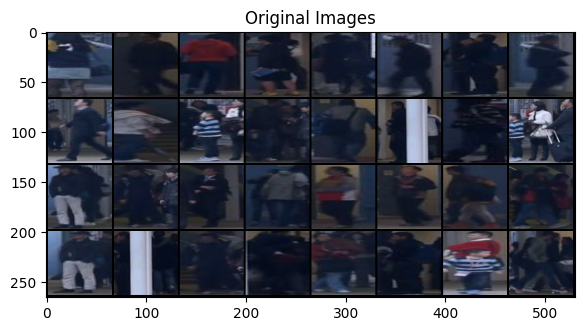

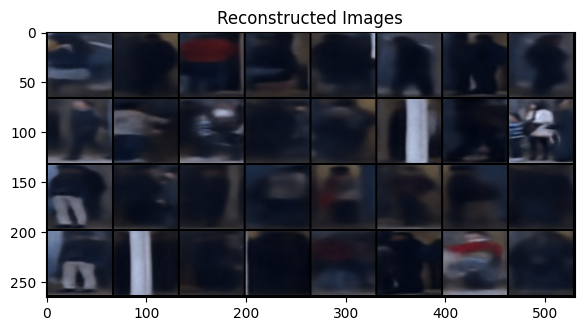

In [21]:
# Get a batch of images from your dataloader
dataiter = iter(train_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = model_inf(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

# Move images back to cpu for visualization
images = images.cpu()
reconstructed_imgs = reconstructed_imgs.cpu()

# Display original and reconstructed images
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Original Images')
imshow(vutils.make_grid(images, padding=2, normalize=True))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.title('Reconstructed Images')
imshow(vutils.make_grid(reconstructed_imgs, padding=2, normalize=True))

## Save model state dict

In [22]:
# Save the decoder state dictionary
torch.save(decoder.state_dict(), 'decoder_state_dict_adamw_40e_numblocks_2_ffdim_4096_heads_16_mseloss_0.05.pth')

## Load Model state dict

In [33]:
# Assuming the decoder class is defined and named `UpsampleTransformerDecoder`

# Initialize the decoder
decoder = UpsampleTransformerDecoder(
    input_channels=384,
    num_upsamples=5,  # Adjusted to 5 upsampling steps
    num_blocks=2,
    num_heads=16,
    ff_dim=2048,
    output_channels=3
)
decoder = decoder.to(device)

state_dict = torch.load('decoder_state_dict_adamw_35e_numblocks_2_ffdim_2048_heads_16_mseloss_0.06.pth')

# Load the state dictionary
decoder.load_state_dict(state_dict)

# If you are using a GPU for the model, don't forget to move the decoder to the GPU
decoder.to(device)

UpsampleTransformerDecoder(
  (up_blocks): ModuleList(
    (0): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(384, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU()
    )
    (1): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(192, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU()
    )
    (2): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(96, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU()
    )
    (3): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(48, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU()
    )
    (4): Sequential(
      (0): Upsample(scale_factor=2.0, mode=bilinear)
      (1): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): GELU()
    )
  )
  (transformer_blocks): ModuleList(
    (0): ModuleList(
      

## Declare Test Data Loader

In [23]:
test_dataset = datasets.ImageFolder(root='../datasets/Avenue Dataset/objects/test/', transform=transform)

# Create the DataLoader to load the dataset.
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

print(test_dataset)

Dataset ImageFolder
    Number of datapoints: 39231
    Root location: ../datasets/Avenue Dataset/objects/test/
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


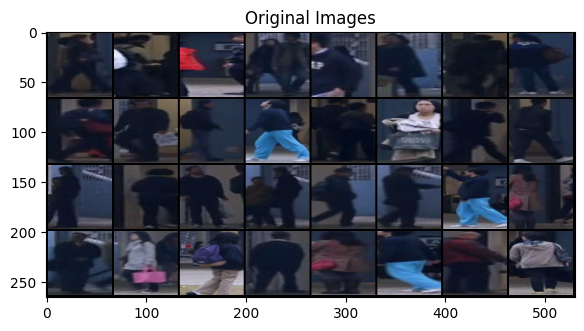

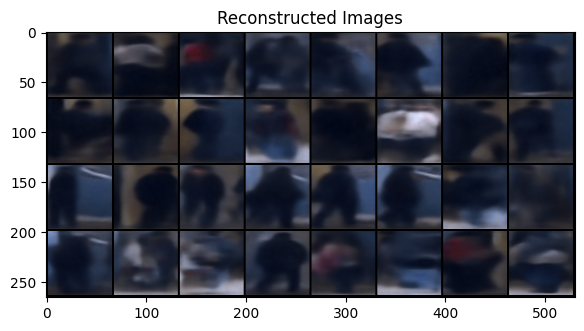

In [24]:
# Get a batch of images from your dataloader
dataiter = iter(test_loader) # or your specific dataloader
images, labels = next(dataiter)

# Move images to the device your model is on
images = images.to(device)

# Forward pass through encoder and then decoder
with torch.no_grad():  # We don't need to track gradients for the encoder
    latent_representation = model_inf(images)[-1]  # Get the last latent space representation
    reconstructed_imgs = decoder(latent_representation)

# Move images back to cpu for visualization
images = images.cpu()
reconstructed_imgs = reconstructed_imgs.cpu()

# Display original and reconstructed images
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Original Images')
imshow(vutils.make_grid(images, padding=2, normalize=True))

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.title('Reconstructed Images')
imshow(vutils.make_grid(reconstructed_imgs, padding=2, normalize=True))